<a href="https://colab.research.google.com/github/Lambda-School-Labs/bridges-to-prosperity-ds-e/blob/main/notebooks/katie_semi_supervized_models_mvp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for problem 2 as described in `B2P Dataset_2020.10.xlsx` Contextual Summary tab:

## Problem 2: Predicting which sites will be technically rejected in future engineering reviews

> Any sites with a "Yes" in the column AQ (`Senior Engineering Review Conducted`) have undergone a full technical review, and of those, the Stage (column L) can be considered to be correct. (`Bridge Opportunity: Stage`)

> Any sites without a "Yes" in Column AQ (`Senior Engineering Review Conducted`) have not undergone a full technical review, and the Stage is based on the assessor's initial estimate as to whether the site was technically feasible or not. 

> We want to know if we can use the sites that have been reviewed to understand which of the sites that haven't yet been reviewed are likely to be rejected by the senior engineering team. 

> Any of the data can be used, but our guess is that Estimated Span, Height Differential Between Banks, Created By, and Flag for Rejection are likely to be the most reliable predictors.


### Load the data

In [9]:
import pandas as pd
url = 'https://github.com/Lambda-School-Labs/bridges-to-prosperity-ds-d/blob/main/Data/B2P%20Dataset_2020.10.xlsx?raw=true'
df = pd.read_excel(url, sheet_name='Data')

### Define the target

In [10]:
# Any sites with a "Yes" in the column "Senior Engineering Review Conducted"
# have undergone a full technical review, and of those, the 
# "Bridge Opportunity: Stage" column can be considered to be correct.
positive = (
    (df['Senior Engineering Review Conducted']=='Yes') & 
    (df['Bridge Opportunity: Stage'].isin(['Complete', 'Prospecting', 'Confirmed']))
)

negative = (
    (df['Senior Engineering Review Conducted']=='Yes') & 
    (df['Bridge Opportunity: Stage'].isin(['Rejected', 'Cancelled']))
)

# Any sites without a "Yes" in column Senior Engineering Review Conducted" 
# have not undergone a full technical review ...
# So these sites are unknown and unlabeled
unknown = df['Senior Engineering Review Conducted'].isna()

# Create a new column named "Good Site." This is the target to predict.
# Assign a 1 for the positive class and 0 for the negative class.
df.loc[positive, 'Good Site'] = 1
df.loc[negative, 'Good Site'] = 0

# Assign -1 for unknown/unlabled observations. 
# Scikit-learn's documentation for "Semi-Supervised Learning" says, 
# "It is important to assign an identifier to unlabeled points ...
# The identifier that this implementation uses is the integer value -1."
# We'll explain this soon!
df.loc[unknown, 'Good Site'] = -1

df['Good Site'].value_counts(dropna=False)

-1.0    1383
 1.0      65
 0.0      24
Name: Good Site, dtype: int64

### Drop columns used to derive the target

In [ ]:
# Because these columns were used to derive the target, 
# We can't use them as features, or it would be leakage.
# df = df.drop(columns=['Senior Engineering Review Conducted', 'Bridge Opportunity: Stage'])

### Look at target's distribution

In [11]:
df['Good Site'].value_counts()

-1.0    1383
 1.0      65
 0.0      24
Name: Good Site, dtype: int64

In [6]:
list(df.describe())

['Bridge Opportunity: GPS (Latitude)',
 'Bridge Opportunity: GPS (Longitude)',
 'Bridge Opportunity: Span (m)',
 'Bridge Opportunity: Individuals Directly Served',
 'Proposed Bridge Location (GPS) (Latitude)',
 'Proposed Bridge Location (GPS) (Longitude)',
 'Days per year river is flooded',
 'River crossing deaths in last 3 years',
 'River crossing injuries in last 3 years',
 'Estimated span (m)',
 'Height differential between banks',
 'Good Site']

Not using because they have a majority null values:
* Bridge Opportunity: Bridge Type 
* Bridge Opportunity: Span (m) 
* Bridge Opportunity: Comments 
* Rejection Reason
* Height differential between banks
* Bridge Opportunity: General Project Photos

Not using due to leakage:
* Senior Engineering Review Conducted
* Bridge Opportunity: Stage

Not using because it's a duplicate:
* Proposed Bridge Location (GPS) (Latitude) 
* Proposed Bridge Location (GPS) (Longitude)

In [5]:
df.isnull().sum()

Bridge Name                                           0
Bridge Opportunity: Project Code                      0
Bridge Opportunity: Needs Assessment                 40
Bridge Opportunity: Level 1 Government                0
Bridge Opportunity: Level 2 Government                0
Bridge Opportunity: Stage                             0
Bridge Opportunity: GPS (Latitude)                   12
Bridge Opportunity: GPS (Longitude)                  12
Bridge Opportunity: Bridge Type                    1287
Bridge Opportunity: Span (m)                       1082
Bridge Opportunity: Individuals Directly Served       6
Bridge Opportunity: Comments                       1078
Form: Form Name                                       0
Form: Created By                                      0
Proposed Bridge Location (GPS) (Latitude)            40
Proposed Bridge Location (GPS) (Longitude)           40
Current crossing method                             160
Nearest all-weather crossing point              

### Wrangle the data

In [12]:
import numpy as np

def wrangle(X):

  X['Bridge classification'] = X['Bridge classification'].replace({np.nan: "unknown"})

  X['Cell service quality'] = X['Cell service quality'].replace({np.nan: "unknown"})

  X['4WD Accessibility'] = X['4WD Accessibility'].replace({np.nan: "unknown"})

  X['Bridge Type'] = X['Bridge Type'].replace({np.nan: "unknown"})
  
  X['Estimated span (m)'] = X['Estimated span (m)'].replace({np.nan: X['Estimated span (m)'].median()})

  X['Bridge Opportunity: Individuals Directly Served'] = X['Bridge Opportunity: Individuals Directly Served'].replace({np.nan: X['Bridge Opportunity: Individuals Directly Served'].median()})

  X['Days per year river is flooded'] = X['Days per year river is flooded'].replace({np.nan: X['Days per year river is flooded'].median()})

  X['River crossing deaths in last 3 years'] = X['River crossing deaths in last 3 years'].replace({np.nan: X['River crossing deaths in last 3 years'].median()})

  X['River crossing injuries in last 3 years'] = X['River crossing injuries in last 3 years'].replace({np.nan: X['River crossing injuries in last 3 years'].median()})
  
  X['Bridge Opportunity: GPS (Latitude)'] = X['Bridge Opportunity: GPS (Latitude)'].replace({np.nan: X['Bridge Opportunity: GPS (Latitude)'].median()})

  X['Bridge Opportunity: GPS (Longitude)'] = X['Bridge Opportunity: GPS (Longitude)'].replace({np.nan: X['Bridge Opportunity: GPS (Longitude)'].median()})


  crossing = []
  for i in X['Current crossing method']:
    if type(i) == float:
      crossing.append("unknown")
    elif 'timber' in i.lower() or 'log' in i.lower():
      crossing.append('timber')
    elif 'boat' in i.lower():
      crossing.append('boat')
    else:
      crossing.append(i.lower())
  X['crossing'] = crossing
  
  return X

### Make a semi-supervized model and use it generate labels for unknown data points

In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.semi_supervised import LabelSpreading


target = 'Good Site'

features = ['Bridge classification', 'crossing', 'Days per year river is flooded',
            'River crossing deaths in last 3 years', 'River crossing injuries in last 3 years',
            'Cell service quality', '4WD Accessibility', 'Bridge Type',
            'Bridge Opportunity: GPS (Latitude)', 'Bridge Opportunity: GPS (Longitude)',
            'Estimated span (m)', 'Bridge Opportunity: Individuals Directly Served']


labels = df[target]
X = wrangle(df)
X = X[features]
enc = OrdinalEncoder()


enc.fit(X)

X = enc.transform(X)

label_spread = LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(X, labels)

output_labels = label_spread.transduction_

df['knn'] = output_labels
df['knn'].value_counts(normalize=True)


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


1.0    0.735054
0.0    0.264946
Name: knn, dtype: float64

### Compare the percentages of the labeled data with the predictions for the dataset as a whole.

In [17]:
print("Original Data")
orig = df[df['Good Site'].isin([0,1])]
print(orig['Good Site'].value_counts(normalize=True))
print("\n")
print("Semi-Supervized Predictions")
print(df['knn'].value_counts(normalize=True))

Original Data
1.0    0.730337
0.0    0.269663
Name: Good Site, dtype: float64


Semi-Supervized Predictions
1.0    0.735054
0.0    0.264946
Name: knn, dtype: float64


### Make categorical labels for easier visualization.

In [18]:
df['Site Suitability'] = df['Good Site']
df['Site Suitability'] = df['Site Suitability'].replace({-1:'Unknown',
                                       0:'Unsuitable',
                                       1:'Suitable'})

df['Predicted Suitability'] = df['knn']
df['Predicted Suitability'] = df['Predicted Suitability'].replace({
                                       0:'Unsuitable',
                                       1:'Suitable'})

### Make graphs showing how it made decisions based on latitude and longitude (though other factors contributed)

In [19]:
import plotly.express as px

graph = df[(
    (df['Proposed Bridge Location (GPS) (Latitude)'] < -1) & 
    (df['Proposed Bridge Location (GPS) (Longitude)'] > 20)
)]

fig = px.scatter(graph, x="Proposed Bridge Location (GPS) (Latitude)", y="Proposed Bridge Location (GPS) (Longitude)", color='Predicted Suitability')
fig.show()

fig = px.scatter(graph, x="Proposed Bridge Location (GPS) (Latitude)", y="Proposed Bridge Location (GPS) (Longitude)", color='Site Suitability')
fig.show()

### Make the same graphs but on a map because it's fun to see.

In [20]:
fig = px.scatter_mapbox(graph, lat="Proposed Bridge Location (GPS) (Latitude)", lon="Proposed Bridge Location (GPS) (Longitude)", hover_name="Predicted Suitability", hover_data=["Predicted Suitability", "Predicted Suitability"],
                        color="Predicted Suitability", zoom=3, height=300)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [21]:
fig = px.scatter_mapbox(graph, lat="Proposed Bridge Location (GPS) (Latitude)", lon="Proposed Bridge Location (GPS) (Longitude)", hover_name="Site Suitability", hover_data=["Predicted Suitability", "Predicted Suitability"],
                        color="Site Suitability", zoom=3, height=300)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Re-shape the dataframe slightly and download.

In [22]:
df = df[['Bridge Name',
 'Bridge Opportunity: Project Code',
 'Bridge Opportunity: Needs Assessment',
 'Bridge Opportunity: Level 1 Government',
 'Bridge Opportunity: Level 2 Government',
 'Bridge Opportunity: Stage',
 'Bridge Opportunity: GPS (Latitude)',
 'Bridge Opportunity: GPS (Longitude)',
 'Bridge Opportunity: Bridge Type',
 'Bridge Opportunity: Span (m)',
 'Bridge Opportunity: Individuals Directly Served',
 'Bridge Opportunity: Comments',
 'Form: Form Name',
 'Form: Created By',
 'Proposed Bridge Location (GPS) (Latitude)',
 'Proposed Bridge Location (GPS) (Longitude)',
 'Current crossing method',
 'Nearest all-weather crossing point',
 'Days per year river is flooded',
 'Flood duration during rainy season',
 'Market access blocked by river',
 'Education access blocked by river',
 'Health access blocked by river',
 'Other access blocked by river',
 'Primary occupations',
 'Primary crops grown',
 'River crossing deaths in last 3 years',
 'River crossing injuries in last 3 years',
 'Incident descriptions',
 'Notes on social information',
 'Cell service quality',
 '4WD Accessibility',
 'Name of nearest city',
 'Name of nearest paved or sealed road',
 'Bridge classification',
 'Flag for Rejection',
 'Rejection Reason',
 'Bridge Type',
 'Estimated span (m)',
 'Height differential between banks',
 'Bridge Opportunity: General Project Photos',
 'Bridge Opportunity: CaseSafeID',
 'Senior Engineering Review Conducted',
 'Good Site',
 'crossing',
 'knn',
 'Site Suitability',
 'Predicted Suitability']]

In [23]:
df = df.to_csv('bridges_predictions3.csv', index=False)

from google.colab import files
files.download('bridges_predictions3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

So we have 65 labeled observations for the positive class, 24 labeled observations for the negative class, and almost 1,400 unlabeled observations.

### 4 recommendations:

- Use **semi-supervised learning**, which "combines a small amount of labeled data with a large amount of unlabeled data". See Wikipedia notes below. Python implementations are available in [scikit-learn](https://scikit-learn.org/stable/modules/label_propagation.html) and [pomegranate](https://pomegranate.readthedocs.io/en/latest/semisupervised.html). Another way to get started: feature engineering + feature selection + K-Means Clustering + PCA in 2 dimensions. Then visualize the clusters on a scatterplot, with colors for the labels.
- Use [**leave-one-out cross-validation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation), without an independent test set, because we have so few labeled observations. It's implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html). Or maybe 10-fold cross-validation with stratified sampling (and no independent test set).
- Consider **"over-sampling"** techniques for imbalanced classification. Python implementations are available in [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn).
- Consider using [**Snorkel**](https://www.snorkel.org/) to write "labeling functions" for "weakly supervised learning." The site has many [tutorials](https://www.snorkel.org/use-cases/). 



### [Semi-supervised learning - Wikipedia](https://en.wikipedia.org/wiki/Semi-supervised_learning)

> Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training. Semi-supervised learning falls between unsupervised learning (with no labeled training data) and supervised learning (with only labeled training data).

> Unlabeled data, when used in conjunction with a small amount of labeled data, can produce considerable improvement in learning accuracy. The acquisition of labeled data for a learning problem often requires a skilled human agent ... The cost associated with the labeling process thus may render large, fully labeled training sets infeasible, whereas acquisition of unlabeled data is relatively inexpensive. In such situations, semi-supervised learning can be of great practical value.

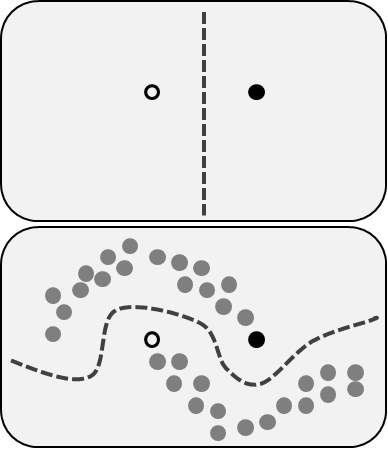

> An example of the influence of unlabeled data in semi-supervised learning. The top panel shows a decision boundary we might adopt after seeing only one positive (white circle) and one negative (black circle) example. The bottom panel shows a decision boundary we might adopt if, in addition to the two labeled examples, we were given a collection of unlabeled data (gray circles). This could be viewed as performing clustering and then labeling the clusters with the labeled data, pushing the decision boundary away from high-density regions ...

See also:

- “Positive-Unlabeled Learning”
- https://en.wikipedia.org/wiki/One-class_classification